In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import datetime
import pandas as pd
import numpy as np
from functools import partial
from dateutil import parser as dtparser

from utils.datafetch import *
from utils.vectorized_funs import *
from utils.datapipe import *
from utils.kerasutil import *
from FintechCapstone import FinCapstone

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [71]:
date_from = '2009-01-01'
date_to = '2017-03-01'
timespan = {
    "short_term": [1, 5]
    ,"medium_term": [40]
    ,"long_term": [90]
}

timespan_ab = {
    "short_term": []
    ,"medium_term": [30]
    ,"long_term": []
}

#trial = FinCapstone(ticker_list=["AAPL", "GOOG", "DIS", "NFLX", "EA", "TWTR"], ticker_list_samplesize=4, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)
trial = FinCapstone(ticker_list_samplesize=200, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)

In [15]:
trial.run_initial_dataload()

(1/6) Recv. and Stored AAPL
(2/6) Recv. and Stored GOOG
(3/6) Recv. and Stored DIS
(4/6) Recv. and Stored NFLX
(5/6) Recv. and Stored EA
(6/6) Recv. and Stored TWTR
Took 0:00:03.582936


In [16]:
trial.feature_engineering(feature_set="baseline")



 - AAPL - 

| | START     - 2017-04-08 15:49:48.965212
 V  END       - 2017-04-08 15:49:48.979434 (TOOK 0:00:00.014222)
| | START     - 2017-04-08 15:49:49.010480
 V  END       - 2017-04-08 15:49:49.024024 (TOOK 0:00:00.013544)


 - GOOG - 

| | START     - 2017-04-08 15:49:49.068372
 V  END       - 2017-04-08 15:49:49.082306 (TOOK 0:00:00.013934)
| | START     - 2017-04-08 15:49:49.113276
 V  END       - 2017-04-08 15:49:49.126843 (TOOK 0:00:00.013567)


 - DIS - 

| | START     - 2017-04-08 15:49:49.194423
 V  END       - 2017-04-08 15:49:49.208695 (TOOK 0:00:00.014272)
| | START     - 2017-04-08 15:49:49.239661
 V  END       - 2017-04-08 15:49:49.253289 (TOOK 0:00:00.013628)


 - NFLX - 

| | START     - 2017-04-08 15:49:49.298054
 V  END       - 2017-04-08 15:49:49.311787 (TOOK 0:00:00.013733)
| | START     - 2017-04-08 15:49:49.342500
 V  END       - 2017-04-08 15:49:49.356437 (TOOK 0:00:00.013937)


 - EA - 

| | START     - 2017-04-08 15:49:49.409559
 V  END       - 2017-04-08

In [234]:
%ls -l data/

ls: cannot access data/l: No such file or directory


In [197]:
%ls -l data/C_BASELINE/

total 3312
-rw-r--r-- 1 jovyan users 198414 Apr  8 12:49 AAPL_baseline_X.csv
-rw-r--r-- 1 jovyan users 198414 Apr  8 12:49 AAPL_baseline_Y.csv
-rw-r--r-- 1 jovyan users 198276 Apr  8 12:49 DIS_baseline_X.csv
-rw-r--r-- 1 jovyan users 198276 Apr  8 12:49 DIS_baseline_Y.csv
-rw-r--r-- 1 jovyan users 197128 Apr  8 12:49 EA_baseline_X.csv
-rw-r--r-- 1 jovyan users 197128 Apr  8 12:49 EA_baseline_Y.csv
-rw-r--r-- 1 jovyan users 159962 Apr  5 20:25 FCCY_baseline_X.csv
-rw-r--r-- 1 jovyan users 159962 Apr  5 20:25 FCCY_baseline_Y.csv
-rw-r--r-- 1 jovyan users 190433 Apr  5 20:25 FLWS_baseline_X.csv
-rw-r--r-- 1 jovyan users 190433 Apr  5 20:25 FLWS_baseline_Y.csv
-rw-r--r-- 1 jovyan users 199062 Apr  8 12:49 GOOG_baseline_X.csv
-rw-r--r-- 1 jovyan users 199062 Apr  8 12:49 GOOG_baseline_Y.csv
-rw-r--r-- 1 jovyan users 197123 Apr  8 12:49 NFLX_baseline_X.csv
-rw-r--r-- 1 jovyan users 197123 Apr  8 12:49 NFLX_baseline_Y.csv
-rw-r--r-- 1 jovyan users  67528 Apr  5 20:27 PIH_baseline_X.csv
-rw-r-

In [198]:
_r = load_raw_frame("NFLX")
_r

,Date,Open,High,Low,Close,Volume,Adj Close
0,2002-05-23,16.190000,17.399999,16.040000,16.750000,104790000,1.196429
1,2002-05-24,17.000000,17.150000,16.760000,16.940001,11104800,1.210000
2,2002-05-28,16.990000,17.249999,16.200000,16.200000,6609400,1.157143
3,2002-05-29,16.299999,16.299999,15.200001,15.450000,6757800,1.103571
4,2002-05-30,15.510000,15.510000,15.000000,15.000000,10154200,1.071429
5,2002-05-31,15.100000,15.100000,15.000000,15.069999,8464400,1.076429
6,2002-06-03,15.120001,16.089999,15.069999,15.799999,3151400,1.128571
7,2002-06-04,15.900000,15.960000,15.550000,15.649999,3105200,1.117857
8,2002-06-05,15.550000,16.229999,15.499999,16.060000,1531600,1.147143
9,2002-06-06,16.100000,17.249999,16.079999,16.550000,2305800,1.182143


In [199]:
X = trial.calc_baseline_features(_r)
y = trial.calc_baseline_labels(_r)

| | START     - 2017-04-08 12:49:39.757476
 V  END       - 2017-04-08 12:49:39.777683 (TOOK 0:00:00.020207)
| | START     - 2017-04-08 12:49:39.777892
\ / RETURNS - 0:00:00.040186
 V  END       - 2017-04-08 12:49:39.818139 (TOOK 0:00:00.040247)


In [10]:
X.head()

,Date,timewindow_return_1_Open,timewindow_return_1_High,timewindow_return_1_Low,timewindow_return_1_Volume
0,2002-05-23,1.000000e-128,1.000000e-128,1.000000e-128,1.000000e-128
1,2002-05-24,5.003088e-02,-1.436776e-02,4.488778e-02,-8.940281e-01
2,2002-05-28,-5.882353e-04,5.830845e-03,-3.341289e-02,-4.048159e-01
3,2002-05-29,-4.061218e-02,-5.507247e-02,-6.172833e-02,2.245287e-02
4,2002-05-30,-4.846620e-02,-4.846620e-02,-1.315796e-02,5.025896e-01


In [11]:
y.head()

,Date,timewindow_return_90_Close,timewindow_return_40_Close,timewindow_return_1_Close,timewindow_return_5_Close
0,2002-05-23,-0.432836,-0.021493,0.011343,-0.100299
1,2002-05-24,-0.521842,-0.052538,-0.043684,-0.067296
2,2002-05-28,-0.552469,-0.037037,-0.046296,-0.033951
3,2002-05-29,-0.575405,-0.060841,-0.029126,0.039482
4,2002-05-30,-0.615333,-0.186667,0.004667,0.103333


In [12]:
trial.store_baseline_features(X, "NFLX")
trial.store_baseline_labels(y, "NFLX")

True

In [13]:
trial.load_baseline_features("NFLX").head()

,Date,timewindow_return_1_Open,timewindow_return_1_High,timewindow_return_1_Low,timewindow_return_1_Volume
0,2002-05-23,1.000000e-128,1.000000e-128,1.000000e-128,1.000000e-128
1,2002-05-24,5.003088e-02,-1.436776e-02,4.488778e-02,-8.940281e-01
2,2002-05-28,-5.882353e-04,5.830845e-03,-3.341289e-02,-4.048159e-01
3,2002-05-29,-4.061218e-02,-5.507247e-02,-6.172833e-02,2.245287e-02
4,2002-05-30,-4.846620e-02,-4.846620e-02,-1.315796e-02,5.025896e-01


In [14]:
trial.load_baseline_labels("NFLX").head()

,Date,timewindow_return_90_Close,timewindow_return_40_Close,timewindow_return_1_Close,timewindow_return_5_Close
0,2002-05-23,-0.432836,-0.021493,0.011343,-0.100299
1,2002-05-24,-0.521842,-0.052538,-0.043684,-0.067296
2,2002-05-28,-0.552469,-0.037037,-0.046296,-0.033951
3,2002-05-29,-0.575405,-0.060841,-0.029126,0.039482
4,2002-05-30,-0.615333,-0.186667,0.004667,0.103333


In [15]:
labels_df = trial.load_baseline_labels("NFLX")
labels_df.set_index("Date", inplace=True)
labels_df.head()

,timewindow_return_90_Close,timewindow_return_40_Close,timewindow_return_1_Close,timewindow_return_5_Close
Date,,,,
2002-05-23,-0.432836,-0.021493,0.011343,-0.100299
2002-05-24,-0.521842,-0.052538,-0.043684,-0.067296
2002-05-28,-0.552469,-0.037037,-0.046296,-0.033951
2002-05-29,-0.575405,-0.060841,-0.029126,0.039482
2002-05-30,-0.615333,-0.186667,0.004667,0.103333


In [243]:
features_df = trial.load_baseline_features("NFLX")
features_df.set_index("Date", inplace=True)
features_df.head()

,timewindow_return_1_Open,timewindow_return_1_High,timewindow_return_1_Low,timewindow_return_1_Volume
Date,,,,
2009-01-02,1.000000e-128,1.000000e-128,1.000000e-128,1.000000e-128
2009-01-05,2.608394e-02,4.721311e-02,2.448976e-02,9.748834e-01
2009-01-06,6.107633e-02,4.101440e-02,6.673317e-02,-7.502012e-02
2009-01-07,2.706907e-02,-3.308241e-03,-4.046063e-03,-1.601207e-01
2009-01-08,-2.059988e-02,1.327701e-02,-1.875000e-02,-1.932721e-01


In [62]:
train_from = trial.train_from
train_until = trial.train_until
test_from = trial.test_from

X_train, y_train, X_test, y_test = baseline_train_test_split(features_df, labels_df, trial.train_from, trial.train_until, trial.test_from)

In [63]:
arrs = [X_train, y_train, X_test, y_test]
arrs_names = ["X_train", "y_train", "X_test", "y_test"]

1
2
1
2
1
2
1
2


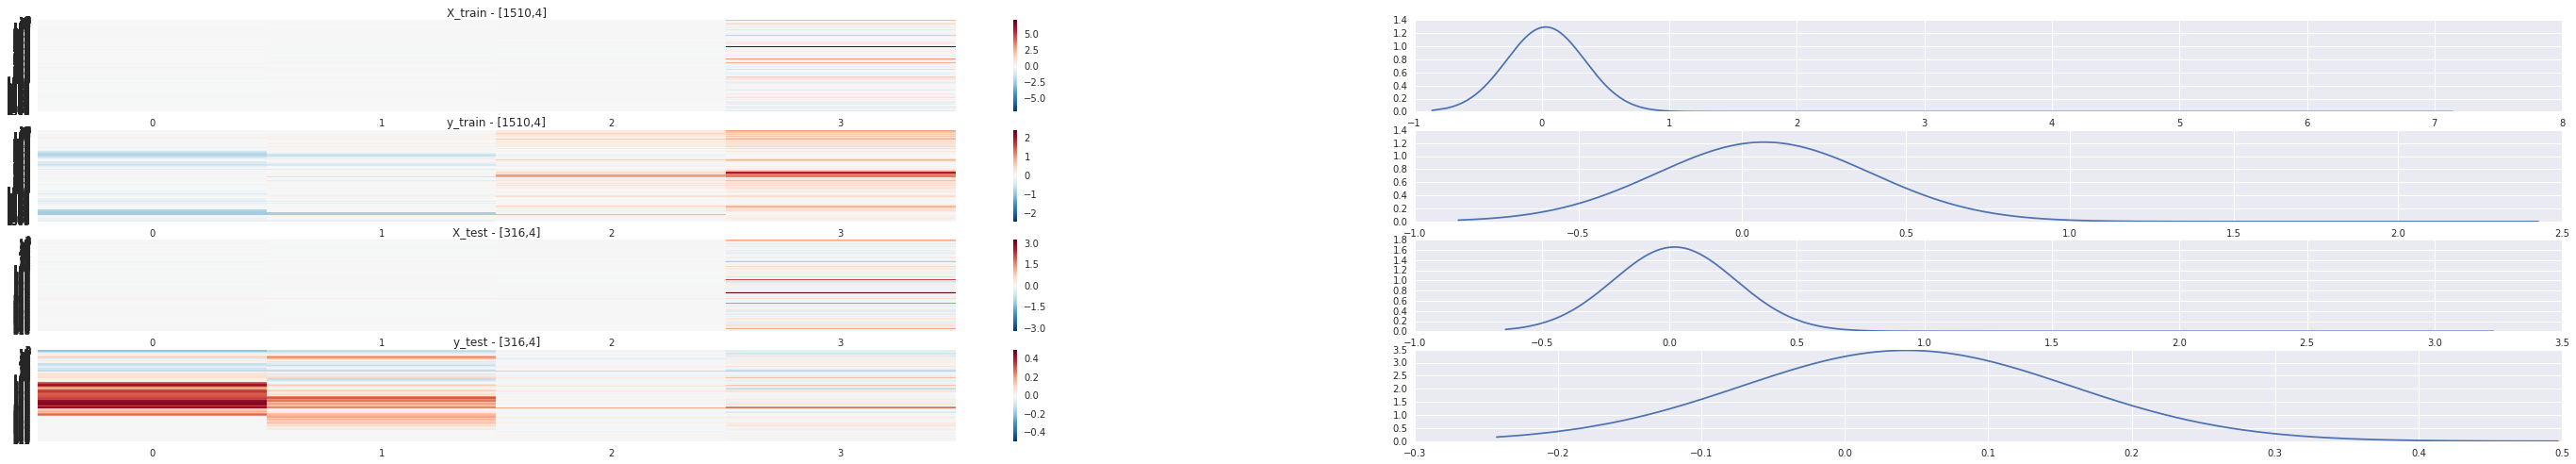

In [74]:
import scipy.stats as stats

fig, ax = plt.subplots(4,2, figsize=(48, 8))

for idx, itr in enumerate(arrs):
    print(1)
    ax[idx, 0].set_title("{} - [{},{}]".format(arrs_names[idx], itr.shape[0], itr.shape[1]))
    sns.heatmap(itr, ax=ax[idx, 0])
    
    print(2)
    h = np.sort(itr.flatten())
    fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
    ax[idx,1].plot(h,fit)

    #sns.distplot(itr.flatten(), ax=[idx, 1])



In [ ]:
import scipy.stats as stats
import pylab as pl

fig, ax = plt.subplots(4,1, figsize=(12, 6))

h = sorted([186, 176, 158, 180, 186, 168, 168, 164, 178, 170, 189, 195, 172,
     187, 180, 186, 185, 168, 179, 178, 183, 179, 170, 175, 186, 159,
     161, 178, 175, 185, 175, 162, 173, 172, 177, 175, 172, 177, 180])  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

ax[0].plot(h,fit,'-o')
ax[2].plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()                   #use may also need add this 


In [ ]:
print(X_test.values.shape)
print(X_test.values.max())
print(X_test.values.min())
print(X_test.values.mean())
print(X_test.values.std())


In [ ]:

print(X_test.values.flatten().shape)
print(X_test.values.flatten().max())
print(X_test.values.flatten().min())
print(X_test.values.flatten().mean())
print(X_test.values.flatten().std())


In [89]:
_stocks = dict()
_stocks["list"] = trial.valid_ticker_list()
_stocks["dframes"] = dict()

for ticker in _stocks["list"]:
    _stocks["dframes"][ticker] = trial.load_baseline_features(ticker, parseDate=True)
    _stocks["dframes"][ticker].set_index("Date", inplace=True)
    _stocks["dframes"][ticker].where(np.isfinite(_stocks["dframes"][ticker]), 1e-128, inplace=True)
    

In [90]:
pnl = pd.Panel(_stocks["dframes"])
pnl.fillna(1e-128, inplace=True)

In [91]:
_itr_date = dtparser.parse("2014-11-06")
pnl.ix[:,_itr_date,:]

,AAAP,AAL,AAOI,AAON,AAPL,ABAC,ABAX,ABCB,ABDC,ABEO,...,SHLM,SMCP,SQZZ,SRCE,SWIN,TURN,TWOU,UHAL,VNET,XLRN
timewindow_return_1_Open,1.000000e-128,-0.016851,0.003793,-0.046342,-0.004583,-0.021552,0.010983,0.001619,-0.015244,-0.125000,...,0.019346,1.000000e-128,1.000000e-128,0.003158,1.000000e-128,-0.034364,-0.027174,-0.006306,-0.043696,-0.038048
timewindow_return_1_High,1.000000e-128,0.017993,-0.002486,0.018537,-0.004666,-0.025424,0.004222,-0.016562,-0.034322,-0.125000,...,0.021460,1.000000e-128,1.000000e-128,0.000939,1.000000e-128,-0.024055,-0.019022,0.010533,-0.031364,-0.019165
timewindow_return_1_Low,1.000000e-128,0.011879,0.017647,-0.042021,-0.003052,0.004566,0.005821,0.005282,-0.018800,-0.235808,...,0.007714,1.000000e-128,1.000000e-128,0.021070,1.000000e-128,-0.007092,0.018944,0.004842,-0.063768,-0.006371
timewindow_return_1_Volume,1.000000e-128,0.255742,1.313274,0.113990,-0.065910,3.125000,-0.175038,-0.602815,0.841379,7.250000,...,0.129154,1.000000e-128,1.000000e-128,-0.288043,1.000000e-128,-0.215010,-0.318966,1.365169,0.473493,-0.165610


1.0000000000000001e-128

In [92]:
print(pnl.max().max().max())

13336.25


In [220]:
360096

360096

In [18]:
pnl.values.nbytes / 1024 / 1024

12.26275634765625

In [97]:
7000 * 2082 * 500

7287000000

In [111]:
model = baseline_binary_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_41 (Dense)             (None, 4096)              20480     
_________________________________________________________________
dense_42 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_43 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_44 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_45 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 4097      
Total para

In [37]:
features_df = trial.load_baseline_features("GOOG", parseDate=True)
features_df.set_index("Date", inplace=True)

labels_df = trial.load_baseline_labels("GOOG", parseDate=True)
labels_df.set_index("Date", inplace=True)


In [42]:
model = baseline_binary_model()

In [43]:
X_train, y_train, X_test, y_test = baseline_train_test_split(features_df, labels_df, trial.train_from, trial.train_until, trial.test_from)

In [52]:
baseline_fit_and_eval(model, X_train, y_train, X_test, y_test)

Epoch 1/2
1510/1510 [==============================] - 0s - loss: 5.7874e-04     
Epoch 2/2
1510/1510 [==============================] - 0s - loss: 0.0029     


0.2664576802507837

In [33]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)


accuracy_score((y_test > 0.0) * 1.0, (y_pred > 0.0) * 1.0)


0.21630094043887146

In [53]:
trial.load_train_eval_baseline()

| | START     - 2017-04-08 16:08:01.724549
\ / 0/6 - AAPL - 0:00:00.003422
Epoch 1/2
1510/1510 [==============================] - 0s - loss: 0.0147     
Epoch 2/2
1510/1510 [==============================] - 0s - loss: 0.0021     
\ / 1/6 - GOOG - 0:00:02.079016
Epoch 1/2
1510/1510 [==============================] - 0s - loss: 0.2000     
Epoch 2/2
1510/1510 [==============================] - 0s - loss: 0.1242     
\ / 2/6 - DIS - 0:00:02.270248
Epoch 1/2
1510/1510 [==============================] - 0s - loss: 0.0131     
Epoch 2/2
1510/1510 [==============================] - 0s - loss: 0.0010         
\ / 3/6 - NFLX - 0:00:02.101238
Epoch 1/2
1510/1510 [==============================] - 0s - loss: 0.0613     
Epoch 2/2
1510/1510 [==============================] - 0s - loss: 0.0090     
\ / 4/6 - EA - 0:00:02.042351
Epoch 1/2
1510/1510 [==============================] - 0s - loss: 0.0199     
Epoch 2/2
1510/1510 [==============================] - 0s - loss: 0.0011     
\ / 5/6 - TWTR -

array([0.18495297805642633, 0.28526645768025077, 0.23197492163009403,
       0.20689655172413793, 0.25391849529780564, 0.14420062695924765], dtype=object)